In [1]:
import pandas as pd
from matplotlib import pyplot as plt

<Axes: xlabel='t'>

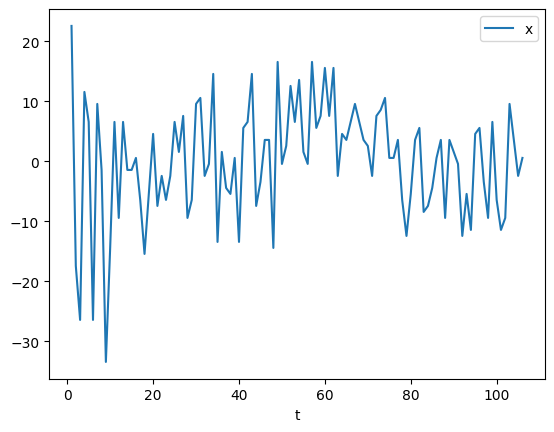

In [2]:
df = pd.read_csv('data/Annual_rainfall_eastern_USA_1817_1922.csv').set_index('t').sort_index()
df.plot()

<h3>Проверка на стационарность</h3>

In [3]:
from statsmodels.tsa.stattools import adfuller

def DF_test(df):
    alpha = 0.05

    print(f'Тест Дики-Фуллера ряда:')
    dftest = adfuller(df, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])

    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print(dfoutput)

    if dfoutput["p-value"] < alpha:
        print(f"Значение p меньше {alpha * 100}%. Ряд стационарный.")
    else:
        print(f"Значение p больше {alpha*100}%. Ряд не стационарный.")

In [4]:
DF_test(df)

Тест Дики-Фуллера ряда:
Test Statistic                -9.820696e+00
p-value                        5.347990e-17
#Lags Used                     0.000000e+00
Number of Observations Used    1.050000e+02
Critical Value (1%)           -3.494220e+00
Critical Value (5%)           -2.889485e+00
Critical Value (10%)          -2.581676e+00
dtype: float64
Значение p меньше 5.0%. Ряд стационарный.


<h3>Удаление тренда и проверка на стационарность</h3>

In [5]:
nottrend = []
s = 6

# выборка без тренда
for i in range(2, len(df['x'])):
   nottrend.append(df['x'][i] - df['x'][i-1])

df_nottrend = pd.DataFrame(nottrend)

<Axes: >

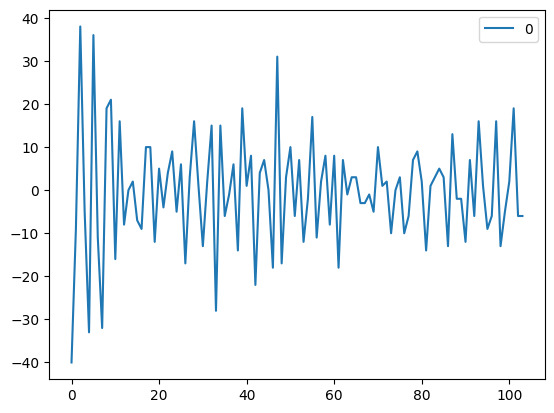

In [6]:
df_nottrend.plot()

In [7]:
DF_test(df_nottrend)

Тест Дики-Фуллера ряда:
Test Statistic                -6.937767e+00
p-value                        1.043907e-09
#Lags Used                     7.000000e+00
Number of Observations Used    9.600000e+01
Critical Value (1%)           -3.500379e+00
Critical Value (5%)           -2.892152e+00
Critical Value (10%)          -2.583100e+00
dtype: float64
Значение p меньше 5.0%. Ряд стационарный.


<h3>Удаление сезонности и проверка на стационарность</h3>

In [8]:
s = 6
notseason = []

# выборка без сезонности
for i in range(s+1, len(df["x"])):
   notseason.append(df["x"][i] - df["x"][i-s])

df_notseason = pd.DataFrame(notseason)

<Axes: >

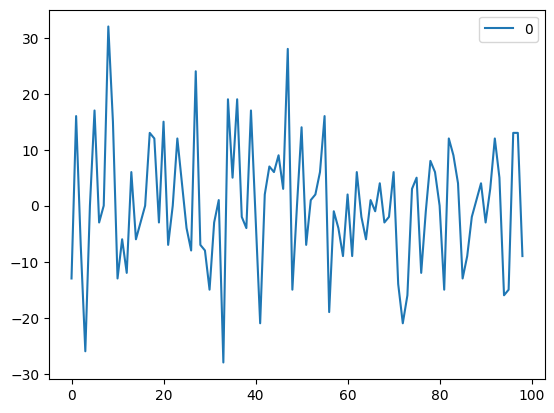

In [9]:
df_notseason.plot()

In [10]:
DF_test(df_notseason)

Тест Дики-Фуллера ряда:
Test Statistic                -6.103644e+00
p-value                        9.700847e-08
#Lags Used                     5.000000e+00
Number of Observations Used    9.300000e+01
Critical Value (1%)           -3.502705e+00
Critical Value (5%)           -2.893158e+00
Critical Value (10%)          -2.583637e+00
dtype: float64
Значение p меньше 5.0%. Ряд стационарный.


<h3>Автокорреляция</h3>

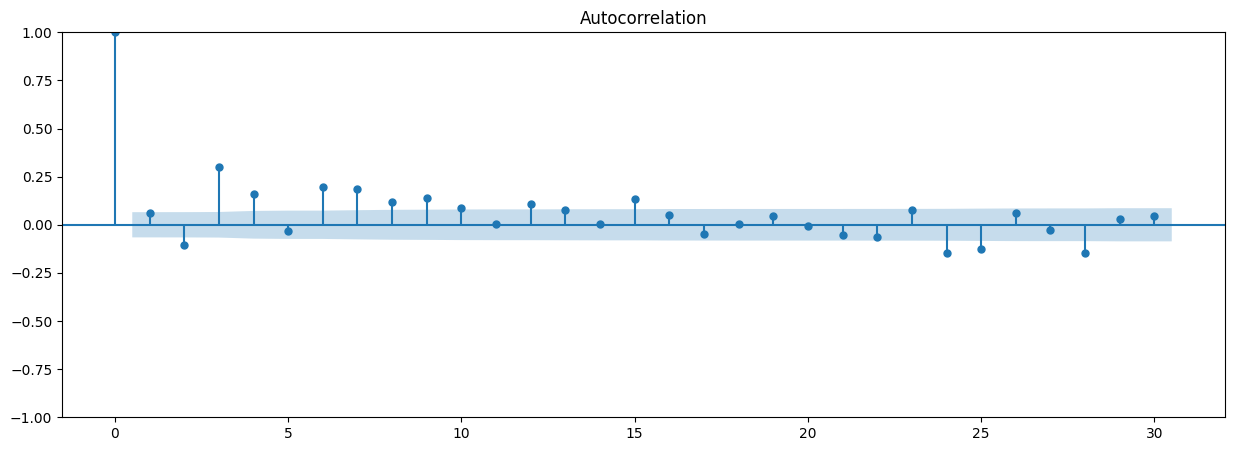

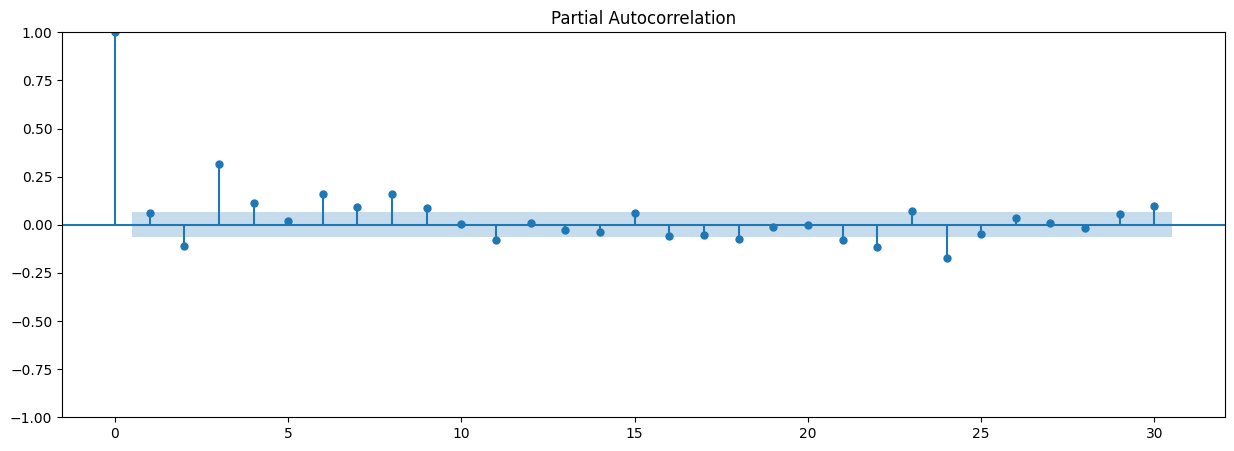

In [11]:
import statsmodels.tsa.api as smt

from pylab import rcParams
rcParams['figure.figsize'] = 15, 5

ac_plot = smt.graphics.plot_acf(df, lags=30, alpha=0.5)

pac_plot = smt.graphics.plot_pacf(df, lags=30, alpha=0.5)

<h3>AR модель</h3>

In [12]:
df.head()

,x
t,
1,22.54
2,-17.46
3,-26.46
4,11.54
5,6.54


In [13]:
df['t'] = df.index.values

ln = len(df)

# указываем 'объемы' выборок
train_cutoff = int(round(ln*0.75, 0))
validate_cutoff = int(round(ln*0.9,0))

# делим выборки
train_df = df[df['t'] <= train_cutoff]
validate_df = df[(df['t'] > train_cutoff) & (df['t'] <= validate_cutoff)]
forecast_df = df[df['t'] > validate_cutoff]

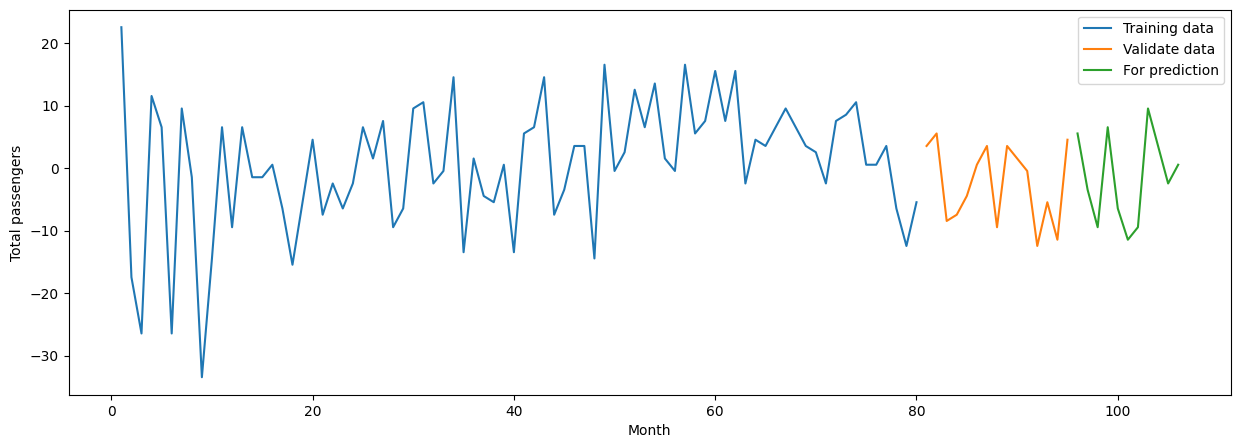

In [14]:
plt.plot(train_df.t, train_df.x, label='Training data')
plt.plot(validate_df.t, validate_df.x, label='Validate data')
plt.plot(forecast_df.t, forecast_df.x, label='For prediction')
plt.legend()
plt.ylabel('Total passengers')
plt.xlabel('Month')
plt.show()

In [15]:
from statsmodels.tsa.ar_model import AutoReg, ar_select_order

In [44]:
mod = AutoReg(train_df.x, 6, old_names=False)
# обучаем
res = mod.fit()

print(res.summary())

                            AutoReg Model Results                             
Dep. Variable:                      x   No. Observations:                   80
Model:                     AutoReg(6)   Log Likelihood                -261.186
Method:               Conditional MLE   S.D. of innovations              8.253
Date:                Tue, 20 Feb 2024   AIC                            538.372
Time:                        16:34:31   BIC                            556.805
Sample:                             6   HQIC                           545.725
                                   80                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.5233      0.981      0.534      0.594      -1.399       2.446
x.L1           0.1018      0.112      0.907      0.364      -0.118       0.322
x.L2           0.0386      0.113      0.342      0.7

/home/alt/micromamba/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


/home/alt/micromamba/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/home/alt/micromamba/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(
/home/alt/micromamba/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/home/alt/micromamba/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exceptio

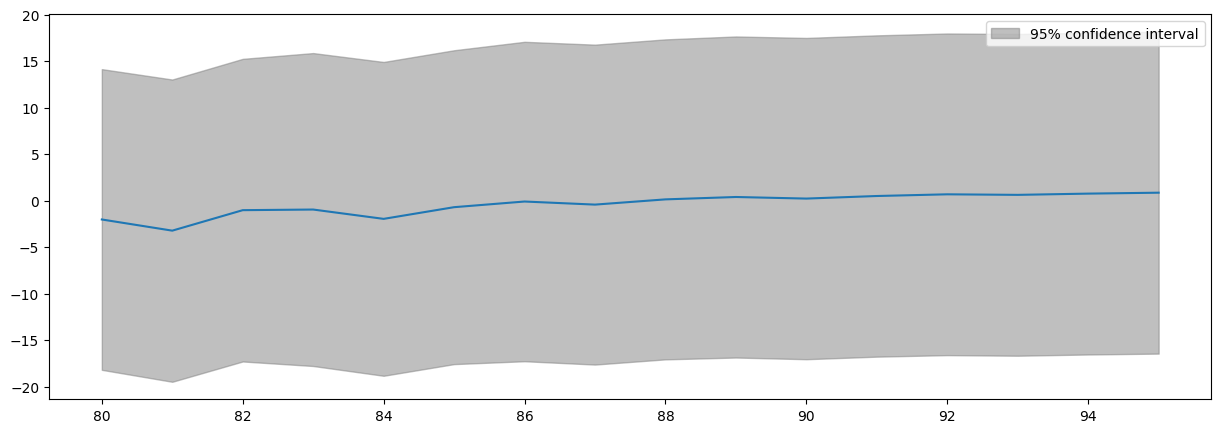

In [45]:
fig = res.plot_predict(train_cutoff, validate_cutoff)

In [46]:
pred = res.predict(start=0, end=train_cutoff, dynamic=False)
v_pred = res.predict(start=train_cutoff+1, end=(validate_cutoff), dynamic=False)
f_pred = res.predict(start=validate_cutoff + 1, end=(forecast_df.t[len(df.t)-1]), dynamic=False)


/home/alt/micromamba/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/home/alt/micromamba/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/home/alt/micromamba/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(
/home/alt/micromamba/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_inde

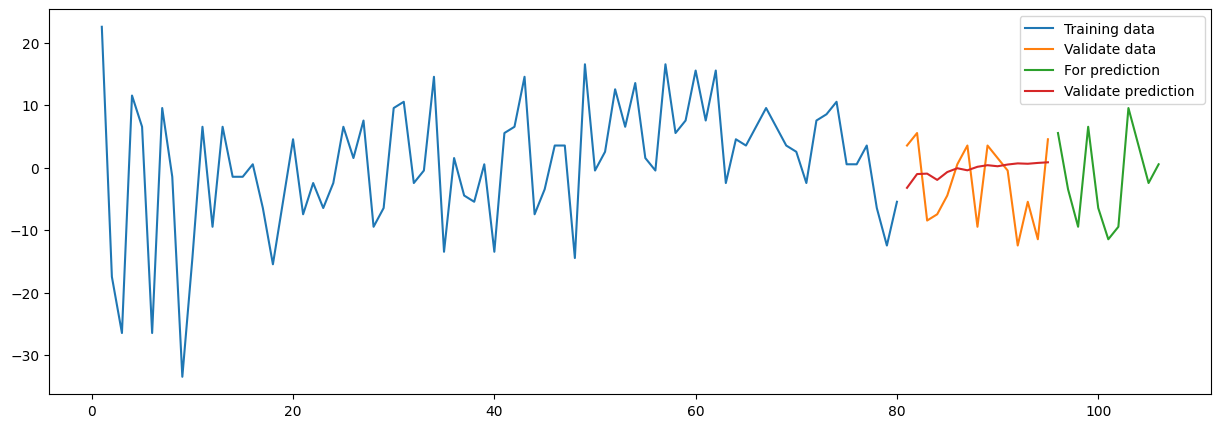

In [47]:


plt.plot(train_df.t, train_df.x, label='Training data')
plt.plot(validate_df.t, validate_df.x, label='Validate data')
plt.plot(forecast_df.t, forecast_df.x, label='For prediction')
plt.plot(validate_df.t, v_pred, label='Validate prediction ')
#plt.plot(forecast_df.t, f_pred, label='Forecast prediction')
#plt.plot(train_df.t, pred, label='Train prediction')

plt.legend()
plt.show()

